# 5分钟对话微调修改Qwen-7b的自我认知

支持多轮和单轮对话数据集的大模型高效微调范例。
构造了一个修改大模型自我认知的3轮对话的玩具数据集，

**使用QLoRA算法，只需要5分钟的训练时间，就可以完成微调，并成功修改了LLM模型的自我认知。**

通过借鉴FastChat对各种开源LLM模型进行数据预处理方法统一管理的方法


> 本范例适用于非常多不同的开源LLM模型，包括 Qwen-7b-Chat，Llama-13b-chat, BaiChuan2-13b-chat, Intern-7b-chat, ChatGLM2-6b-chat 以及其它许许多多FastChat支持的模型。


在多轮对话模式下,我们按照如下格式构造包括多轮对话中所有机器人回复内容的标签。

(注：llm.build_inputs_labels(messages,multi_rounds=True) 时采用)

```

inputs = <user1> <assistant1> <user2> <assistant2> <user3> <assistant3>
labels = <-100> <assistant1> <-100> <assistant2> <-100> <assistant3>

```


在单轮对话模式下，我们仅将最后一轮机器人的回复作为要学习的标签。

(注：llm.build_inputs_labels(messages,multi_rounds=False)时采用)


```
inputs = <user1> <assistant1> <user2> <assistant2> <user3> <assistant3>
labels = <-100> <-100> <-100> <-100> <-100> <assistant3>

```







## 一、数据集进行处理

这里是客服和坐席进行通话的文本

- 1）没有对原始文本做预处理降噪
- 2）需要构造微调的prompt


In [1]:
%mkdir rawdata

In [2]:
!sudo apt-get install unzip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [6]:
!unzip rawdata/test_dataset.zip -d rawdata/

Archive:  rawdata/test_dataset.zip
  inflating: rawdata/test_dataset.csv  


In [11]:
!unzip rawdata/train_dataset.zip -d rawdata/

Archive:  rawdata/train_dataset.zip
  inflating: rawdata/train_dataset.csv  


In [7]:
!ls rawdata/ -lht

total 47M
-rw-r--r-- 1 root root  12M Apr 21 07:55 train_dataset.xlsx
-rw-r--r-- 1 root root 8.0M Apr 21 07:55 test_dataset.zip
-rw-r--r-- 1 root root  27M Sep 29  2021 test_dataset.csv


In [9]:
import pandas as pd

In [38]:
train_df = pd.read_excel("rawdata/train_dataset.xlsx")

In [39]:
train_df.head(3)

,id,content,abstract,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 98,Unnamed: 99,Unnamed: 100,Unnamed: 101,Unnamed: 102,Unnamed: 103,Unnamed: 104,Unnamed: 105,Unnamed: 106,Unnamed: 107
0,0,【坐席】您好，实习话务员为您，【客户】服务，喂，你好，是这样的，我那个我的电话因为上次突然把...,用户来电反映手机号卡收费问题，用户称现在怎么欠费167.65，我方经查询用户有10月欠费76...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,【客户】嗯，【坐席】，很高兴为您服务，【客户】喂，你好，你好，我想问一下，我没有去过这个吉林...,用户来电反映查询漫游地，显示有吉林，用户称没有去过附近，要求核实回复，请处理谢谢,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,【客户】嗯，【坐席】，您好，实习话务员为您服务，【客户】喂你好，然后我这某某人卡，然后有有两...,用户来电想要取消20元语音特惠包（200分钟另得100条短信）-立即生效，我方取消不成功，用...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
train_df = train_df[['id', 'content', 'abstract', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']]

train_df = train_df.fillna("")

In [41]:
from tqdm import tqdm

cnt = 0
for i, row in tqdm(train_df.iterrows()):
  abstract = row['abstract']
  if 0 == len(abstract):
    abstract = row['Unnamed: 3'] +  row['Unnamed: 4'] +  row['Unnamed: 5']
    train_df.at[i, 'abstract'] = abstract
    cnt += 1

25001it [00:01, 16233.94it/s]


In [42]:
print(cnt)

61


In [43]:
train_df.head(3)

,id,content,abstract,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,0,【坐席】您好，实习话务员为您，【客户】服务，喂，你好，是这样的，我那个我的电话因为上次突然把...,用户来电反映手机号卡收费问题，用户称现在怎么欠费167.65，我方经查询用户有10月欠费76...,,,
1,1,【客户】嗯，【坐席】，很高兴为您服务，【客户】喂，你好，你好，我想问一下，我没有去过这个吉林...,用户来电反映查询漫游地，显示有吉林，用户称没有去过附近，要求核实回复，请处理谢谢,,,
2,2,【客户】嗯，【坐席】，您好，实习话务员为您服务，【客户】喂你好，然后我这某某人卡，然后有有两...,用户来电想要取消20元语音特惠包（200分钟另得100条短信）-立即生效，我方取消不成功，用...,,,


In [44]:
train_df["len"] = train_df["abstract"].apply(len)
train_df["len"].describe()

count    25001.000000
mean        93.825087
std         45.562906
min          0.000000
25%         70.000000
50%         86.000000
75%        109.000000
max        865.000000
Name: len, dtype: float64

In [48]:
train_df = train_df[train_df["len"] > 10]
train_df["len"].describe()

count    24591.000000
mean        95.300191
std         44.472686
min         11.000000
25%         71.000000
50%         87.000000
75%        109.000000
max        865.000000
Name: len, dtype: float64

In [52]:
train_df.head(3)

,id,content,abstract
0,0,【坐席】您好，实习话务员为您，【客户】服务，喂，你好，是这样的，我那个我的电话因为上次突然把...,用户来电反映手机号卡收费问题，用户称现在怎么欠费167.65，我方经查询用户有10月欠费76...
1,1,【客户】嗯，【坐席】，很高兴为您服务，【客户】喂，你好，你好，我想问一下，我没有去过这个吉林...,用户来电反映查询漫游地，显示有吉林，用户称没有去过附近，要求核实回复，请处理谢谢
2,2,【客户】嗯，【坐席】，您好，实习话务员为您服务，【客户】喂你好，然后我这某某人卡，然后有有两...,用户来电想要取消20元语音特惠包（200分钟另得100条短信）-立即生效，我方取消不成功，用...


<Axes: >

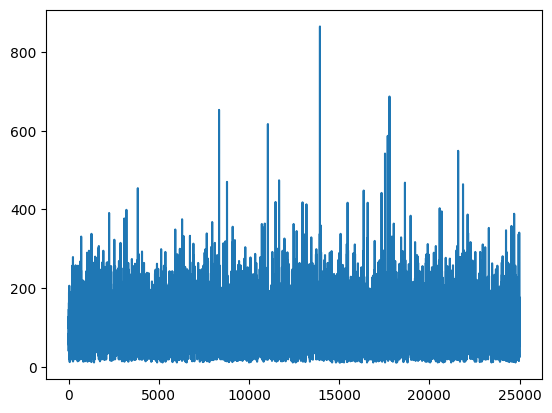

In [53]:
train_df["len"] = train_df["abstract"].apply(len)

train_df['len'].plot()

In [ ]:
train_df["conv_len"] = train_df["content"].apply(len)

In [69]:
train_df = train_df[train_df["conv_len"] > 100]
train_df["conv_len"].describe()

count    24545.000000
mean      1219.124506
std        984.318768
min        103.000000
25%        638.000000
50%        971.000000
75%       1491.000000
max      24413.000000
Name: conv_len, dtype: float64

<Axes: >

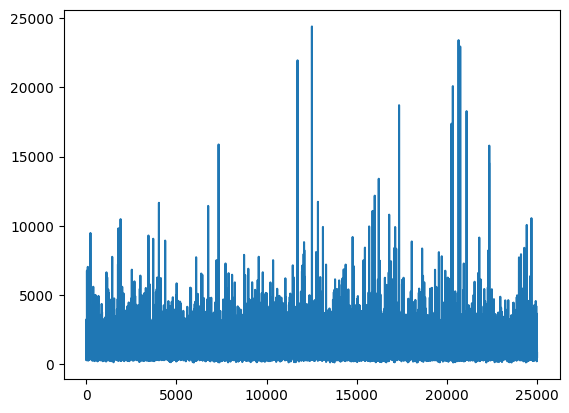

In [70]:
train_df["conv_len"].plot()

In [54]:
# train_df.to_csv("rawdata/train_dataset.csv", encoding="utf-8-sig")

# 直接读取矫正格式后的数据
# test_df = pd.read_csv("rawdata/train_dataset.csv")

In [10]:
test_df = pd.read_csv("rawdata/test_dataset.csv")
test_df.head(3)

,id|content
0,25001|【坐席】您好，实习话务员为您服务，【客户】，唉，你好那个，我刚收到咱们那个话费通...
1,25002|【坐席】您好，很高兴为您服务，【客户】，嗯，你好，那个先说一下那个不太好意思，因...
2,25003|【坐席】您好，很高兴为您服务，您好，【客户】，那个我这个套餐到期了也没人通知我呀...


In [55]:
test_df.columns

Index(['id|content'], dtype='object')

In [56]:
test_df["id"] = test_df["id|content"].apply(lambda x: x[:4])
test_df["id|content"] = test_df["id|content"].apply(lambda x: x[5:])
test_df = test_df.rename(columns={"id|content": "content"})

test_df["len"] = test_df["content"].apply(len)

In [57]:
test_df["len"].describe()

count     7526.000000
mean      1237.574542
std       1044.299993
min         24.000000
25%        645.250000
50%        976.000000
75%       1503.000000
max      29724.000000
Name: len, dtype: float64

<Axes: >

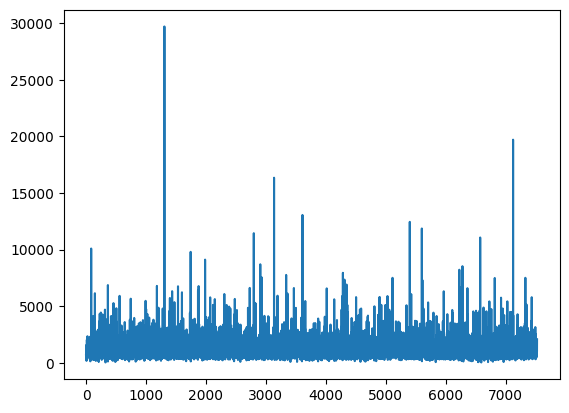

In [58]:
test_df["len"].plot()

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import transformers
print(transformers.__version__)

4.38.2


In [1]:
!pip install peft
import peft
print(peft.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 3.5 MB/s eta 0:00:00
0.10.0


In [3]:
# !pip install accelerate
import accelerate
print(accelerate.__version__)

0.29.2


In [4]:
!pip install torchkeras
import torchkeras
print(torchkeras.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 20.0 MB/s eta 0:00:00
3.9.6


In [4]:
!pip install -i https://pypi.org/simple/ bitsandbytes
!pip show bitsandbytes

Looking in indexes: https://pypi.org/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 8.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using c

## 〇，预训练模型

In [6]:
!pip install tiktoken
# !pip install streamlit==1.24.0
# !pip install sentencepiece==0.1.99
!pip install datasets sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00


In [2]:
!pip install accelerate==0.24.1

In [8]:
!pip install einops transformers_stream_generator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for transformers_stream_generator: filename=transformers_stream_generator-0.0.5-py3-none-any.whl size=12425 sha256=816235b188657d29d5a08d666ac4b2888b1c5005d90ff975dff4942743da7112
  Stored in directory: /root/.cache/pip/wheels/95/4a/90/140f7b67d125906f6a165f38aad212ecb4a695ad0d87582437
Successfully built transformers_stream_generator


In [1]:
!pip install transformers==4.30.0

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM,AutoConfig, AutoModel, BitsAndBytesConfig
from transformers.generation.utils import GenerationConfig
import torch.nn as nn


#使用QLoRA引入的 NF4量化数据类型以节约显存
model_name_or_path ='Qwen/Qwen-7b-Chat'  #远程：'Qwen/Qwen-7b-Chat'

bnb_config=BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False,
        )

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                quantization_config=bnb_config,
                trust_remote_code=True)

model.generation_config = GenerationConfig.from_pretrained(model_name_or_path)


`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/19.5k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.96G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/2.02G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/2.02G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/2.02G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/2.02G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/2.02G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/2.02G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

In [6]:
from torchkeras.chat import ChatLLM
llm = ChatLLM(model, tokenizer)

register magic %%chat sucessed ...


In [7]:
llm.chat(messages=llm.build_messages(query='世界的尽头是哪里？'))

'世界上第二高的山峰是乔戈里峰，位于喜马拉雅山脉中，海拔8611米。'

## 二，准备数据

下面我设计了一个改变LLM自我认知的玩具数据集，这个数据集有三轮对话。

第一轮问题是 who are you?

第二轮问题是 where are you from?

第三轮问题是  what can you do?

差不多是哲学三问吧：你是谁？你从哪里来？你要到哪里去?

通过这三个问题，我们希望初步地改变 大模型的自我认知。

在提问的方式上，我们稍微作了一些数据增强。

所以，总共是有 27个样本。

### 1，导入样本

In [73]:
# format_system=StringFormatter(slots=["<|im_start|>system\n{{content}}<|im_end|>\n"]),
# format_user=StringFormatter(slots=["<|im_start|>user\n{{content}}<|im_end|>\n<|im_start|>assistant\n"]),

summary_prompt = """### Instruction ###
请简洁精炼地总结如下文通信商客服与客户对话的摘要
要求：1、必须保证准确流畅
   2、必须避免篡改和追加对话中没有的信息
   3、必须将字数限制在200字以内

### Input ###
对话:"{dialogs}"

### Output ###
摘要：
"""

def getInputInstruction(dialogs, maxlen=7500):
  return summary_prompt.format(dialogs=dialogs[:maxlen])

dialogs = """【坐席】您好，实习话务员为您，【客户】服务，喂，你好，是这样的，我那个我的电话因为上次突然把给我停机了，我不知道啥意思，然后我就好长时间没有使用，我这次拿着10，怎么我欠费160多了？噢，我想问一下，我这机器现在是在停机状态吧，【坐席】嗯，对是的？【客户】对停机状态，你们怎么还收我费用啊，【坐席】嗯，您稍等这边看的话，先生，咱们这12月份的话是没有收您的费用的，这边是这个产生的费用是您11月份的女士先生，【客户】那我11月份我现在-160，那我想问一下，那我这个怎么能-160？我始终没超一个星期，他就你们就给我停机了，因为那我忙着在外地出差，我就没有，我就没有那个办这个找你们，【坐席】嗯，先生这边看的话，先生，您是一个就是11月份的话，有一个是，嗯，基本套餐费是88块钱，还有您上个月未结清的话费是76块钱，【客户】但是我刚才你们给我反馈那个是我欠160多，【坐席】嗯，对是的先生，就是您这160多，嗯，160多是产生的，是11月份的结转11月份的，总消费是88，还有您10月还有一个是10月份未结清的话，是76块钱？【客户】我没有结清的，我就想问你，你帮我查一下，我打几天电话，我哪来的那个？还有那么多没结清呢，我就不明白，我一个包月电话我都没有打出去多少电话，我这流我这是4000分钟，是两三千分钟啊，那那么多话费我根本都没有打几个，他怎么就我又欠那么多钱呢【坐席】嗯，先生，您这个是阿里大包，嗯，就是三角大大宝卡吗？先生每个月基本月租费是88块钱的，里面是给您包含500分钟通话工作，工作员是二百两千五百分钟，相当于3000分钟吗？先生，还有两个G的流量，【客户】对呀，【坐席】嗯，它这个是如果您，嗯没有超出的话，每个月是收您88块钱的先生，【客户】对呀，那我也没有超出啊，你怎么还有我查，我这还欠那么多费呢【坐席】这嗯，就每个月正常扣您的套餐费用，先生88块钱套餐费用，先生这个是，【客户】对，但是我这个你看一下，你看看你从我开始，我注册这号到停机，您看看我使这几天你你对你们，你查一下看我使了几天，我怎么的就是有这个还有欠费呢，我这还没，我还说实在我找你们，我这使那几天，我那88块钱你们都给我退我，【坐席】嗯这边看的话是在9月份给您给您停的机先生，【客户】对啊，9月份我是9月几号开通的这个卡呀【坐席】嗯，您这是9月1号给您开通的卡先生，【客户】对9月份9月1号开通卡，应该没超过，9月10号，你就把我这个停了应该，【坐席】嗯是的先生，【客户】对呀，那你说那那您您觉得我这个怎么弄，你，你说我该怎么弄？您觉得你们问问你们公司领导，我这个怎么能查算合理呀【坐席】嗯，您看这样好吧先生，就是您这个问题的话，咱们这边给您记录反馈一下，稍后有咱们的专员给您回电，然后到底是这个问题如何给您解决？您看这样吧，先生【客户】行你，【坐席】就联系，嗯好联系电话联系您，哪个手机号码呢先生，【客户】你就联系这个就行，【坐席】嗯，这边的话不是已经是给您暂停服务了，先生这边就怕咱们联系您的话，也是无法无法接听电话的，先生无法打通的，【客户】他给我打那个185，185，1951【坐席】********，嗯，就联系您这个号码了，先生，【客户】4089对【坐席】嗯，您看还有什么问题可以帮您的吗？先生，【客户】没有了，你再给我把这给我解决一下吧，好吧，【坐席】嗯，好，嗯，好的先生，【客户】嗯【坐席】感谢您的来电，请您稍后对服务评价中帮我按个十分满意，谢谢|用户来电反映手机号卡收费问题，用户称现在怎么欠费167.65，我方经查询用户有10月欠费76和11月欠费88，用户称********此号卡是在9月1号开通的，没用几天就别关停服务了(局方停机），我都没有怎么使用，怎么还扣取我的费用，我某某人常解释，用户对超出的费用不认可，请核实处理，谢谢"""
abstract = """客户询问为何其电话在停机状态下仍产生160多元欠费。客服解释160多元欠费来源于11月的基本套餐费88元和10月未结清的话费76元。客户对此不解，称自己拥有大量未使用的通话分钟和流量，并未超出套餐。客户怀疑开通服务至停机期间的费用问题，提到服务在9月初开通后不久就被停机。客服建议记录此问题并反馈给专员，后续会有专人回电解决，并询问了联系方式。客户提供了联系电话，并希望问题能被妥善处理。客服确认并将结束通话，提醒客户进行服务评价时给予满分。"""
conversation = [{"instruction": getInputInstruction(dialogs), "response": abstract}]

In [60]:
import random
def get_messages(conver_pair):
  message_pair = [{"role": "user", "content": conver_pair["instruction"]},
      {"role": "assistant", "content": conver_pair["response"]}]
  return message_pair

In [61]:
get_messages(conversation[0])

[{'role': 'user',
  'content': '### Instruction ###\n请简洁精炼地总结如下文通信商客服与客户对话的摘要 \n要求：1、必须保证准确流畅\n   2、必须避免篡改和追加对话中没有的信息\n   3、必须将字数限制在200字以内\n   \n### Input ###\n对话:"【坐席】您好，实习话务员为您，【客户】服务，喂，你好，是这样的，我那个我的电话因为上次突然把给我停机了，我不知道啥意思，然后我就好长时间没有使用，我这次拿着10，怎么我欠费160多了？噢，我想问一下，我这机器现在是在停机状态吧，【坐席】嗯，对是的？【客户】对停机状态，你们怎么还收我费用啊，【坐席】嗯，您稍等这边看的话，先生，咱们这12月份的话是没有收您的费用的，这边是这个产生的费用是您11月份的女士先生，【客户】那我11月份我现在-160，那我想问一下，那我这个怎么能-160？我始终没超一个星期，他就你们就给我停机了，因为那我忙着在外地出差，我就没有，我就没有那个办这个找你们，【坐席】嗯，先生这边看的话，先生，您是一个就是11月份的话，有一个是，嗯，基本套餐费是88块钱，还有您上个月未结清的话费是76块钱，【客户】但是我刚才你们给我反馈那个是我欠160多，【坐席】嗯，对是的先生，就是您这160多，嗯，160多是产生的，是11月份的结转11月份的，总消费是88，还有您10月还有一个是10月份未结清的话，是76块钱？【客户】我没有结清的，我就想问你，你帮我查一下，我打几天电话，我哪来的那个？还有那么多没结清呢，我就不明白，我一个包月电话我都没有打出去多少电话，我这流我这是4000分钟，是两三千分钟啊，那那么多话费我根本都没有打几个，他怎么就我又欠那么多钱呢【坐席】嗯，先生，您这个是阿里大包，嗯，就是三角大大宝卡吗？先生每个月基本月租费是88块钱的，里面是给您包含500分钟通话工作，工作员是二百两千五百分钟，相当于3000分钟吗？先生，还有两个G的流量，【客户】对呀，【坐席】嗯，它这个是如果您，嗯没有超出的话，每个月是收您88块钱的先生，【客户】对呀，那我也没有超出啊，你怎么还有我查，我这还欠那么多费呢【坐席】这嗯，就每个月正常扣您的套餐费用，先生88块钱套餐费用，先生这个是，【客户】对，但是我这个你看一下，你看看你从我开始，我注册这号到停机，您看看

<Axes: >

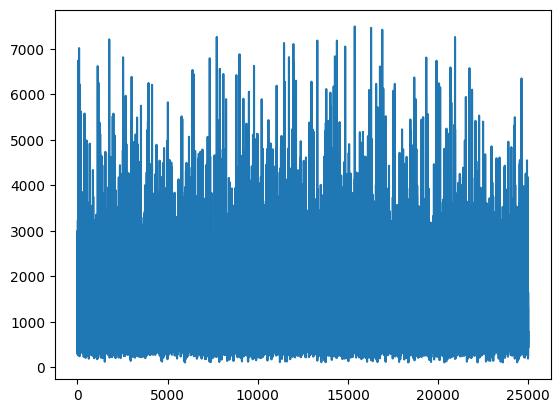

In [71]:
# 实际使用的数据集
THRESHOLD_LEN = 7500
used_train_df = train_df[train_df["conv_len"] < THRESHOLD_LEN]
used_train_df["conv_len"].plot()

In [72]:
used_train_df["conv_len"].describe()

count    24492.000000
mean      1197.319900
std        839.758036
min        103.000000
25%        637.000000
50%        969.500000
75%       1486.000000
max       7496.000000
Name: conv_len, dtype: float64

In [ ]:
train_dialogs = used_train_df["content"]
train_abstracts = used_train_df["abstract"]

conversations = [{"instruction": getInputInstruction(dialogs), "response": abstract} for dialogs, abstract in zip(train_dialogs, train_abstracts) ]

### 2，做数据集

In [13]:
from torch.utils.data import Dataset,DataLoader
from copy import deepcopy

class MyDataset(Dataset):
    def __init__(self, conv, size=8):
      self.conv = conv  # 数据集
      self.index_list = list(range(size))
      self.size = size

    def __len__(self):
        return self.size

    def get(self,index):
      idx = self.index_list[index]
      messages = get_messages(self.conv[idx])
      return messages

    def __getitem__(self,index):
      messages = self.get(index)
      input_ids, labels = llm.build_inputs_labels(messages, multi_rounds=False) #支持多轮
      return {'input_ids':input_ids,'labels':labels}

In [14]:
ds_train = ds_val = MyDataset(conversation)

### 3，创建管道

In [15]:
#如果pad为None，需要处理一下
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.unk_token_id if tokenizer.unk_token_id is not None else tokenizer.eos_token_id


def data_collator(examples: list):

    len_ids = [len(example["input_ids"]) for example in examples]
    longest = max(len_ids) #之后按照batch中最长的input_ids进行padding

    input_ids = []
    labels_list = []

    for length, example in sorted(zip(len_ids, examples), key=lambda x: -x[0]):
        ids = example["input_ids"]
        labs = example["labels"]

        ids = ids + [tokenizer.pad_token_id] * (longest - length)
        labs = labs + [-100] * (longest - length)

        input_ids.append(torch.LongTensor(ids))
        labels_list.append(torch.LongTensor(labs))

    input_ids = torch.stack(input_ids)
    labels = torch.stack(labels_list)
    return {
        "input_ids": input_ids,
        "labels": labels,
    }


In [16]:
import torch
dl_train = torch.utils.data.DataLoader(ds_train,batch_size=2,
                                       pin_memory=True,shuffle=False,
                                       collate_fn = data_collator)

dl_val = torch.utils.data.DataLoader(ds_val,batch_size=2,
                                    pin_memory=True,shuffle=False,
                                     collate_fn = data_collator)


In [17]:
for batch in dl_train:
    pass

In [18]:
#试跑一个batch
out = model(**batch)

In [19]:
out.loss

tensor(4.9062, dtype=torch.float16, grad_fn=<ToCopyBackward0>)

In [20]:
len(dl_train)

4

## 二，定义模型

下面我们将使用QLoRA(实际上用的是量化的AdaLoRA）算法来微调Baichuan-13b模型。

In [21]:
from peft import get_peft_config, get_peft_model, TaskType
model.supports_gradient_checkpointing = True  #
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!


You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


In [22]:
import bitsandbytes as bnb
def find_all_linear_names(model):
    """
    找出所有全连接层，为所有全连接添加adapter
    """
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:  # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)


In [23]:
from peft import prepare_model_for_kbit_training
model = prepare_model_for_kbit_training(model)


You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


In [24]:
lora_modules = find_all_linear_names(model)
print(lora_modules)


['w2', 'c_proj', 'w1', 'c_attn']


In [25]:
from peft import AdaLoraConfig
peft_config = AdaLoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=16,
    lora_alpha=16, lora_dropout=0.08,
    target_modules= lora_modules
)

peft_model = get_peft_model(model, peft_config)

peft_model.is_parallelizable = True
peft_model.model_parallel = True
peft_model.print_trainable_parameters()


trainable params: 26,838,912 || all params: 7,748,163,616 || trainable%: 0.34639062015388394


In [27]:
(7748163616 * 4) / (2**30)

28.864158749580383

## 三，训练模型

In [28]:
from torchkeras import KerasModel
from accelerate import Accelerator

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None,
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator()
        if self.stage=='train':
            self.net.train()
        else:
            self.net.eval()

    def __call__(self, batch):

        #loss
        with self.accelerator.autocast():
            loss = self.net.forward(**batch)[0]

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()

        all_loss = self.accelerator.gather(loss).sum()

        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}

        #metrics (stateful metrics)
        step_metrics = {}

        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics

KerasModel.StepRunner = StepRunner

#仅仅保存QLora可训练参数
def save_ckpt(self, ckpt_path='checkpoint', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)

def load_ckpt(self, ckpt_path='checkpoint'):
    import os
    self.net.load_state_dict(
        torch.load(os.path.join(ckpt_path,'adapter_model.bin')),strict =False)
    self.from_scratch = False

KerasModel.save_ckpt = save_ckpt
KerasModel.load_ckpt = load_ckpt


In [29]:
optimizer = bnb.optim.adamw.AdamW(peft_model.parameters(),
                                  lr=6e-03,is_paged=True)  #'paged_adamw'
keras_model = KerasModel(peft_model,loss_fn =None,
        optimizer=optimizer)

ckpt_path = 'qwen7b_multirounds'


In [30]:
keras_model.from_scratch=False

<<<<<< ⚡️ cuda is used >>>>>>


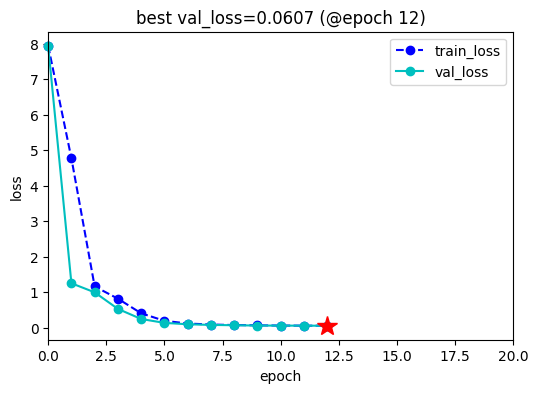

KeyboardInterrupt: 

In [31]:
# keras_model.load_ckpt(ckpt_path) #支持加载微调后的权重继续训练(断点续训)
keras_model.fit(train_data = dl_train,
                val_data = dl_val,
                epochs=100,patience=15,
                monitor='val_loss',mode='min',
                ckpt_path = ckpt_path
               )

## 四，保存模型

为减少GPU压力，此处可重启kernel释放显存

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM,AutoConfig, AutoModel, BitsAndBytesConfig
from transformers.generation.utils import GenerationConfig
import torch.nn as nn
#使用QLoRA引入的 NF4量化数据类型以节约显存
model_name_or_path ='Qwen/Qwen-7b-Chat'
ckpt_path = 'qwen7b_multirounds'


tokenizer = AutoTokenizer.from_pretrained(
   model_name_or_path, trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                trust_remote_code=True)

model.generation_config = GenerationConfig.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [1]:
from peft import PeftModel

# 可能需要5分钟左右
peft_model = PeftModel.from_pretrained(model, ckpt_path)
model_new = peft_model.merge_and_unload()

NameError: name 'model' is not defined

In [ ]:
from transformers.generation.utils import GenerationConfig
model_new.generation_config = GenerationConfig.from_pretrained(model_name_or_path)


In [ ]:
save_path = 'qwen_torchkeras'

In [2]:
tokenizer.save_pretrained(save_path)
model_new.save_pretrained(save_path)

NameError: name 'tokenizer' is not defined

In [ ]:
!cp qwen_7b/*.py  qwen_torchkeras/

In [ ]:
!ls  qwen_torchkeras

## 五，使用模型

为减少GPU压力，此处可再次重启kernel释放显存。

In [ ]:
import warnings
warnings.filterwarnings('ignore')


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM,AutoConfig, BitsAndBytesConfig
from transformers.generation.utils import GenerationConfig
import torch.nn as nn

model_name_or_path =  'qwen_torchkeras'

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=False, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, device_map="auto",
                                             torch_dtype=torch.float16, trust_remote_code=True)
model.generation_config = GenerationConfig.from_pretrained(model_name_or_path)


我们测试一下微调后的效果。

In [ ]:
from torchkeras.chat import ChatLLM
llm = ChatLLM(model,tokenizer)

In [ ]:
%%chat
你好，请介绍一下你自己

In [ ]:
%%chat
你能干嘛呀

In [ ]:
%%chat
你多大了呀

非常棒，粗浅的测试表明，我们的多轮对话训练是成功的。已经在Qwen的自我认知中，种下了一颗梦中情炉的种子。😋😋